# 2D projections for DNN-based reconstruction

Our DNN-based strategy for reconstruction can be described as follows:

Training:
1. Run many events in a box of pure xenon. 
2. Place the event in a random location in the active region and drift all hits to the EL plane (applying both transverse and longitudinal diffusion). Voxelize with some small resolution and store the resulting (x,y,z) coordinates and energies in an HDF5 file.
3. Slice the event in z, that is, make an x-y projection with some chosen pixel size (which may be larger than the x-y dimensions of the chosen voxel size in step 2).
4. Determine the range of all slices (the maximum extent in x and y) and eliminate events containing slices that have a range greater than some chosen value. Collect all slices that fit within the chosen range to be used as training/validation/test events.
5. For the collected slices, construct a corresponding SiPM map with a size large enough to fit the chosen range.
6. Train a DNN to reconstruct slice projections from SiPM maps; (x = [the SiPM map], y = [corresponding projection])

Analysis:
1. We begin with slices created from real data (or data-like MC). In this case we only have access to the SiPM maps and not 
2. Find active regions along the SiPM plane and extract subsets corresponding to our slice region.
3. Reconstruct the slice using the DNN.
4. Piece the track together from the reconstructed slices. The reconstructed slice coordinates will need to be translated into real (x,y) coordinates by considering where in the tracking plane the SiPM subset was taken and the voxel sizes. Also, a multiplicative factor will need to be applied corresponding to the energy weighting of the slice.

In [1]:
%pylab inline

# Sg_vs_Bg_dnn will use magbox SiPM response data to classify tracks into signal or background classes
from   __future__         import print_function
from   keras.optimizers   import SGD, Nadam
from   keras.models       import Sequential, Model, load_model
from   keras.layers       import Input, Dense, Activation, Conv2D, AveragePooling2D, MaxPooling2D, merge, Reshape, Flatten, Dropout
from   keras              import callbacks
from   matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import tables            as tb
import numpy             as np
import copy
import h5py
import sys

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


Define the 3D grid extent and range limits. Note that we have two potentially different voxel sizes: those in which the Geant4 events were originally voxelized ("Geant4 voxels") and those we are using for x-y projections ("projection voxels" - defined below).

In [2]:
# Number of events to read.
nevtsTrain = 30000
nevtsTest = 2000

# SiPM plane geometry definition
nsipm = 10             # number of SiPMs in response map (a 10x10 response map covers a 100x100 range)
sipm_pitch = 10.       # distance between SiPMs
sipm_edge_width = 5.   # distance between SiPM and edge of board

# Range limit in x and y for slices (assuming a square range), in voxels
RNG_LIM = 100

gridSize = int(RNG_LIM*RNG_LIM)
mapSize = nsipm*nsipm

# Range limits from extraction of Geant4-simulated events.
NX = 200
NY = 200
NZ = 200

# Projection voxel sizes in mm
vSizeX = 1
vSizeY = 1

# The slice width, in Geant4 voxels
slice_width = 5.

# -----------------------------------------------------------------------------------------------------------
# Variables for computing an EL point location
xlen = 2*sipm_edge_width + (nsipm-1)*sipm_pitch       # (mm) side length of rectangle
ylen = 2*sipm_edge_width + (nsipm-1)*sipm_pitch       # (mm) side length of rectangle
wbin = 2.0                                            # (mm) bin width
# Compute the positions of the SiPMs
pos_x = np.ones(nsipm**2)*sipm_edge_width + (np.ones(nsipm*nsipm)*range(nsipm**2) % nsipm)*sipm_pitch
pos_y = np.ones(nsipm**2)*sipm_edge_width + np.floor(np.ones(nsipm*nsipm)*range(nsipm**2) / nsipm)*sipm_pitch


In [3]:
# Construct a DNN.
def model_2dconv():
    
    model = Sequential()
    model.add(Reshape((1, nsipm, nsipm), input_shape=(nsipm*nsipm,)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format=None))
    model.add(Conv2D(256, (2, 2), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(5, 5), strides=(5, 5), padding='same', data_format=None))
    model.add(Flatten())
    model.add(Dense(units=RNG_LIM**2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Nadam(
        lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))

    return model

## DNN training and reconstruction

The stored events and SiPM maps can now be read in and used to train a DNN.

In [4]:
def read_events(file_name,nevts_train,nevts_test,map_size,grid_size):

    # Open the HDF5 file.
    evt_file = h5py.File(file_name,'r')
    tot_evts = int(len(evt_file)/5)
    
    # Make sure we have specified valid event numbers.
    if(nevts_train+nevts_test > tot_evts):
        print("ERROR: too many events specified")
        return None
    
    # Make sure we start reading test events on a boundary.
    enum_last = evt_file["evtNum{0}".format(nevts_train-1)][0]
    enum_end  = evt_file["evtNum{0}".format(nevts_train)][0]
    while(enum_last == enum_end):
        nevts_train += 1
        nevts_test  -= 1
        enum_end  = evt_file["evtNum{0}".format(nevts_train)][0]
        
    enum_last = evt_file["evtNum{0}".format(nevts_train+nevts_test-1)][0]
    enum_end  = evt_file["evtNum{0}".format(nevts_train+nevts_test)][0]
    while(enum_last == enum_end and (nevts_train+nevts_test) < tot_evts):
        nevts_test  += 1
        enum_end  = evt_file["evtNum{0}".format(nevts_train+nevts_test)][0]        
    print("Reading {0} training events and {1} test events".format(nevts_train,nevts_test))
        
    # Create the arrays to store the training and test events.
    x_train = np.zeros([nevts_train,map_size])
    x_test = np.zeros([nevts_test,map_size])
    y_train = np.zeros([nevts_train,grid_size])
    y_test = np.zeros([nevts_test,grid_size])
    
    # Create the arrays to store additional information needed to reconstruct entire events (test events only).
    enum_test = np.zeros(nevts_test)
    xc_test = np.zeros(nevts_test)
    yc_test = np.zeros(nevts_test)
    efrac_test = np.zeros(nevts_test)
    
    # Start reading the events.
    print("{0} events available".format(tot_evts))
    nevents = min(tot_evts,nevts_train+nevts_test)
    for ee in range(nevents):

        # Get the data from the HDF5 file.
        slice_obj = evt_file["slice{0}".format(ee)]
        map_obj = evt_file["sipm{0}".format(ee)]
        evtnum_obj = evt_file["evtNum{0}".format(ee)]
        xc_obj = evt_file["xc{0}".format(ee)]
        yc_obj = evt_file["yc{0}".format(ee)]
        efrac_obj = evt_file["efrac{0}".format(ee)]

        # Create the grid.
        xslices = slice_obj[0]; yslices = slice_obj[1]; eslices = slice_obj[2]
        slice_grid = np.zeros(gridSize)
        for xv,yv,ev in zip(xslices,yslices,eslices):
            igrid = int(xv + RNG_LIM*yv)
            slice_grid[igrid] += ev

        # Store the event.
        if(ee >= nevts_train): 
            x_test[ee-nevts_train] = map_obj
            y_test[ee-nevts_train] = slice_grid
            enum_test[ee-nevts_train] = evtnum_obj[0]
            xc_test[ee-nevts_train] = xc_obj[0]
            yc_test[ee-nevts_train] = yc_obj[0]
            efrac_test[ee-nevts_train] = efrac_obj[0]
        else:
            x_train[ee] = map_obj
            y_train[ee] = slice_grid
            
    evt_file.close()
    
    return (x_train, y_train, x_test, y_test, enum_test, xc_test, yc_test, efrac_test)

## Read in the data and train the DNN

In [5]:
x_train, y_train, x_test, y_test, enum_test, xc_test, yc_test, efrac_test = read_events("data/slices.h5",nevtsTrain,nevtsTest,mapSize,gridSize)

Reading 30005 training events and 2001 test events
44965 events available


Plot one event: grid distribution and corresponding SiPM map

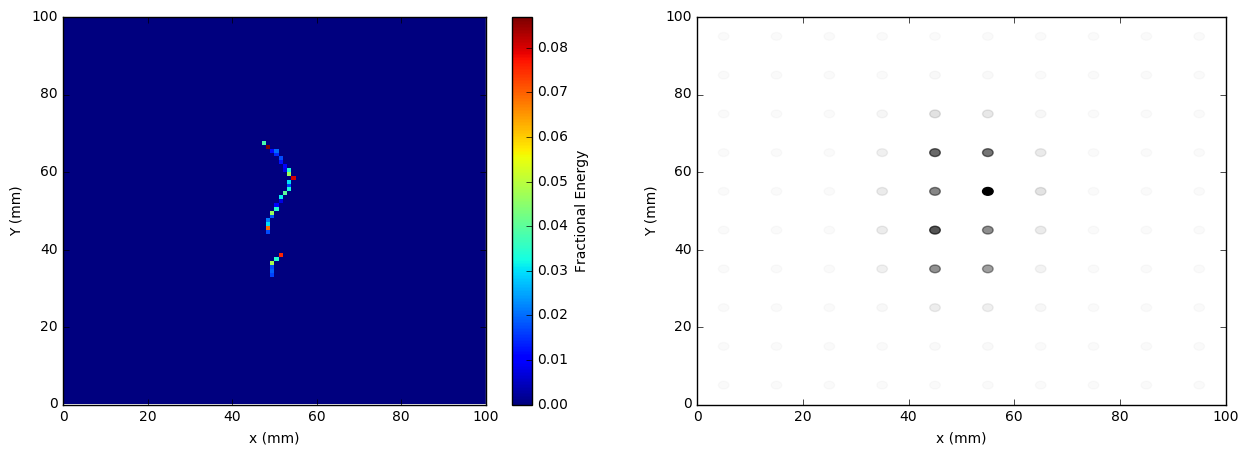

In [6]:
# Plot one event.
plt_train = True   # set to True to plot a training event, False to plot a test event
pevt = 4            # the event number
if(plt_train):
    xarr = x_train[pevt]
    yarr = y_train[pevt]
else:
    xarr = x_test[pevt]
    yarr = y_test[pevt]

# Create the figure.
fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# Plot the SiPM response map.
# Plot the grid.
grid_vals = np.reshape(yarr,(-1,RNG_LIM))
ax2 = fig.add_subplot(121)
extent3 = [0, RNG_LIM, 0, RNG_LIM]
sp3 = ax2.imshow(grid_vals, extent=extent3, interpolation='none', aspect='auto', origin='lower')
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("Y (mm)")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Fractional Energy');

ax1 = fig.add_subplot(122); 
ax1.axis([0, xlen, 0, ylen]);
probs = (xarr - min(xarr))
probs /= max(probs)
for x,y,p in zip(pos_x, pos_y, probs):
    
    # Set up the location; note we must invert y due to a pi rotation
    #  about the x-axis.
    r = Ellipse(xy=(x,y), width=2., height=2.);
    r.set_facecolor('0');
    r.set_alpha(0.02 + 0.98*p);
    ax1.add_artist(r);
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("Y (mm)")

In [7]:
# set load_model to true and specify the file to load in a previously defined/trained model
load_mdl = False
mfile = 'models/slice_reconstruction.h5'

if(load_mdl):
    model = load_model(mfile)
else:

    # otherwise define the model
    model = model_2dconv()
    
    # define callbacks (actions to be taken after each epoch of training)
    file_lbl = "{epoch:02d}-{loss:.4f}"
    filepath="weights-{0}.h5".format(file_lbl)
    checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    tboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=False)
    lcallbacks = [checkpoint, tboard]  
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 10, 10)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 10, 128)        11648     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 5, 256)         131328    
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             2570000   
Total para

In [8]:
hist=model.fit(x_train, y_train, epochs=10, batch_size=50, validation_data=(x_test,y_test), callbacks=lcallbacks)

Train on 30005 samples, validate on 2001 samples
Epoch 1/10
30005/30005 [==============================] - 113s - loss: 5.2821 - val_loss: 4.9967
Epoch 2/10
30005/30005 [==============================] - 114s - loss: 4.5579 - val_loss: 4.3648
Epoch 3/10
30005/30005 [==============================] - 109s - loss: 4.3179 - val_loss: 4.6287
Epoch 4/10
30005/30005 [==============================] - 109s - loss: 4.1736 - val_loss: 4.1036
Epoch 5/10
30005/30005 [==============================] - 104s - loss: 4.0573 - val_loss: 4.2581
Epoch 6/10
30005/30005 [==============================] - 114s - loss: 3.9577 - val_loss: 4.0613
Epoch 7/10
30005/30005 [==============================] - 109s - loss: 3.8730 - val_loss: 3.9987
Epoch 8/10
30005/30005 [==============================] - 103s - loss: 3.8046 - val_loss: 4.0418
Epoch 9/10
30005/30005 [==============================] - 435s - loss: 3.7491 - val_loss: 3.9269
Epoch 10/10
30005/30005 [==============================] - 107s - loss: 3.7018

In [9]:
# Evaluate the model and produce a list of predictions for the test data.
loss_and_metrics = model.evaluate(x_test, y_test);
y_pred = model.predict(x_test, batch_size=32, verbose=0)
print("\nMean loss is {0}".format(loss_and_metrics))

1952/2001 [============================>.] - ETA: 0s
Mean loss is 3.891591417735842


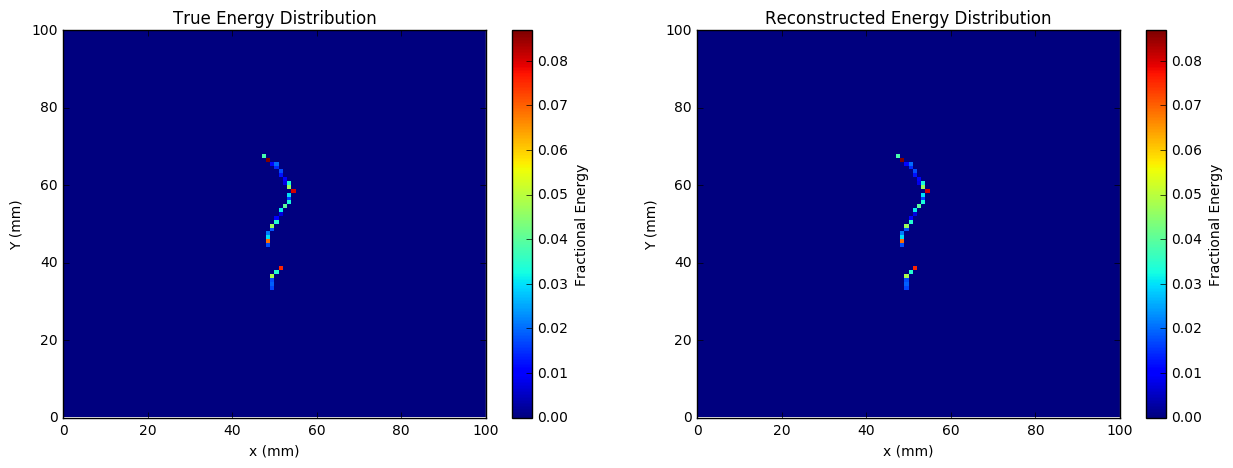

In [10]:
# Plot true vs. reconstructed for a test slice.
pevt = np.random.randint(0,1999)
pevt = 4
xarr = x_train[pevt]
y_true = y_train[pevt]
y_calc = y_train[pevt]

# Create the figure.
fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(15.0)
extent = [0, RNG_LIM, 0, RNG_LIM]

# Plot the truth.
ax1 = fig.add_subplot(121);
grid_true = np.reshape(y_true,(-1,RNG_LIM))
sp3 = ax1.imshow(grid_true, extent=extent, interpolation='none', aspect='auto', origin='lower')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("True Energy Distribution")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Fractional Energy');

ax2 = fig.add_subplot(122)
grid_calc = np.reshape(y_calc,(-1,RNG_LIM))
sp3 = ax2.imshow(grid_calc, extent=extent, interpolation='none', aspect='auto', origin='lower')
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("Y (mm)")
ax2.set_title("Reconstructed Energy Distribution")
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Fractional Energy');

Plot the training and validation loss

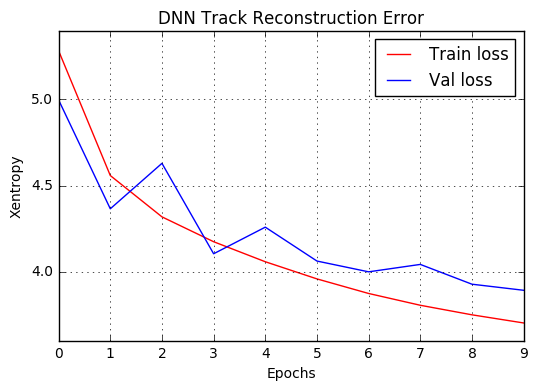

In [11]:
train = plt.plot(range(0,len(hist.history['loss'])),
                 np.array(hist.history['loss']), 'r', label='Train loss')
val   = plt.plot(range(0,len(hist.history['loss'])),
                 np.array(hist.history['val_loss']), 'b', label='Val loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Xentropy')
plt.title('DNN Track Reconstruction Error')
plt.grid(True)
plt.show()

## Plot the projections for a single reconstructed event

In [12]:
# Print some of the event numbers.
print(enum_test[0:100])

[ 3627.  3627.  3627.  3627.  3627.  3627.  3627.  3627.  3627.  3627.
  3627.  3627.  3627.  3627.  3627.  3627.  3627.  3627.  3628.  3628.
  3628.  3628.  3628.  3628.  3628.  3628.  3628.  3628.  3628.  3629.
  3629.  3629.  3629.  3629.  3629.  3629.  3629.  3630.  3630.  3630.
  3630.  3630.  3630.  3630.  3630.  3630.  3630.  3630.  3631.  3631.
  3631.  3631.  3631.  3631.  3631.  3631.  3631.  3631.  3631.  3632.
  3632.  3632.  3632.  3632.  3632.  3632.  3632.  3632.  3632.  3633.
  3633.  3633.  3633.  3633.  3633.  3633.  3633.  3633.  3633.  3633.
  3634.  3634.  3634.  3634.  3634.  3634.  3634.  3634.  3634.  3634.
  3634.  3634.  3634.  3634.  3634.  3634.  3634.  3634.  3634.  3636.]


Energy fraction sum is 1.0


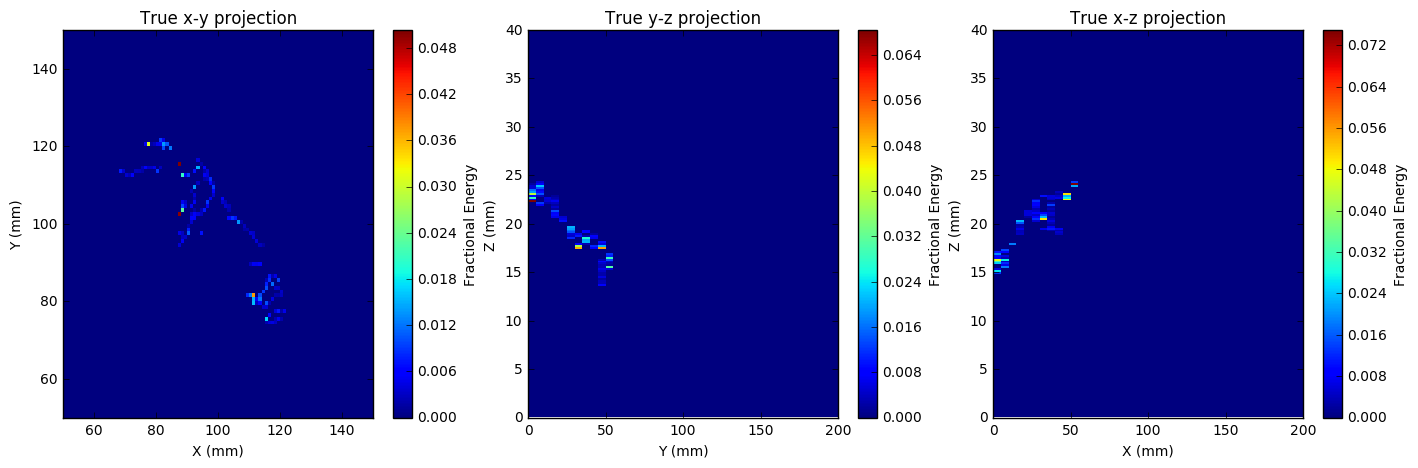

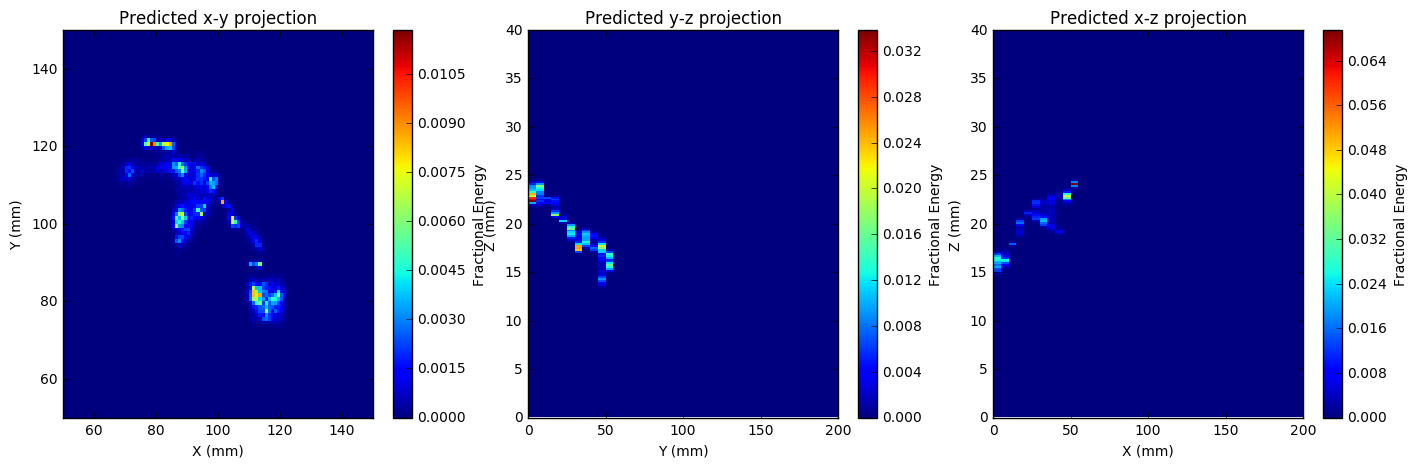

In [13]:
# Get all predictions for a single event and plot them.
plt_evt = 3630

xevt = x_test[enum_test == plt_evt]
yevt = y_test[enum_test == plt_evt]
ymat = np.reshape(yevt,[len(yevt),RNG_LIM,RNG_LIM])
x0 = xc_test[enum_test == plt_evt].astype('int')
y0 = yc_test[enum_test == plt_evt].astype('int')
efrac = efrac_test[enum_test == plt_evt]
print("Energy fraction sum is {0}".format(np.sum(efrac)))

yevt_pred = model.predict(xevt, batch_size=32, verbose=0)
ymat_pred = np.reshape(yevt_pred,[len(yevt_pred),RNG_LIM,RNG_LIM])

extent_xy = [0, RNG_LIM*2, 0, RNG_LIM*2]
extent_yz = [0, RNG_LIM*2, 0, int(RNG_LIM*2/5)]
extent_xz = [0, RNG_LIM*2, 0, int(RNG_LIM*2/5)]

# Create and plot the true projections.
ymat_xy = np.zeros([RNG_LIM*2,RNG_LIM*2])
ymat_yz = np.zeros([RNG_LIM*2, int(RNG_LIM*2/5)])
ymat_xz = np.zeros([RNG_LIM*2, int(RNG_LIM*2/5)])
for nz in range(ymat.shape[0]): 
    ymat_xy[x0[nz]:int(x0[nz]+RNG_LIM),y0[nz]:int(y0[nz]+RNG_LIM)] += ymat[nz,:,:]*efrac[nz]
    ymat_yz[y0[nz]:int(y0[nz]+RNG_LIM),nz] += np.sum(ymat,axis=1)[nz,:]*efrac[nz]
    ymat_xz[x0[nz]:int(x0[nz]+RNG_LIM),nz] += np.sum(ymat,axis=2)[nz,:]*efrac[nz]

fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(17.0)

ax1 = fig.add_subplot(131); 
sp1 = ax1.imshow(ymat_xy, extent=extent_xy, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("True x-y projection")
ax1.set_xlim([50,150])
ax1.set_ylim([50,150])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Fractional Energy')

ax2 = fig.add_subplot(132); 
sp2 = ax2.imshow(ymat_yz, extent=extent_yz, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("Y (mm)")
ax2.set_ylabel("Z (mm)")
ax2.set_title("True y-z projection")
cbp2 = plt.colorbar(sp2)
cbp2.set_label('Fractional Energy')

ax3 = fig.add_subplot(133); 
sp3 = ax3.imshow(ymat_xz, extent=extent_xz, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("X (mm)")
ax3.set_ylabel("Z (mm)")
ax3.set_title("True x-z projection")
cbp3 = plt.colorbar(sp3)
cbp3.set_label('Fractional Energy')

# Create and plot the predicted projections.
ymat_pred_xy = np.zeros([RNG_LIM*2,RNG_LIM*2])
ymat_pred_yz = np.zeros([RNG_LIM*2, int(RNG_LIM*2/5)])
ymat_pred_xz = np.zeros([RNG_LIM*2, int(RNG_LIM*2/5)])
for nz in range(ymat_pred.shape[0]): 
    ymat_pred_xy[x0[nz]:int(x0[nz]+RNG_LIM),y0[nz]:int(y0[nz]+RNG_LIM)] += ymat_pred[nz,:,:]*efrac[nz]
    ymat_pred_yz[y0[nz]:int(y0[nz]+RNG_LIM),nz] += np.sum(ymat_pred,axis=1)[nz,:]*efrac[nz]
    ymat_pred_xz[x0[nz]:int(x0[nz]+RNG_LIM),nz] += np.sum(ymat_pred,axis=2)[nz,:]*efrac[nz]

fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(17.0)

ax1 = fig.add_subplot(131); 
sp1 = ax1.imshow(ymat_pred_xy, extent=extent_xy, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("X (mm)")
ax1.set_ylabel("Y (mm)")
ax1.set_title("Predicted x-y projection")
ax1.set_xlim([50,150])
ax1.set_ylim([50,150])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Fractional Energy')

ax2 = fig.add_subplot(132); 
sp2 = ax2.imshow(ymat_pred_yz, extent=extent_yz, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("Y (mm)")
ax2.set_ylabel("Z (mm)")
ax2.set_title("Predicted y-z projection")
cbp2 = plt.colorbar(sp2)
cbp2.set_label('Fractional Energy')

ax3 = fig.add_subplot(133); 
sp3 = ax3.imshow(ymat_pred_xz, extent=extent_xz, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("X (mm)")
ax3.set_ylabel("Z (mm)")
ax3.set_title("Predicted x-z projection")
cbp3 = plt.colorbar(sp3)
cbp3.set_label('Fractional Energy')